In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
torch.cuda.empty_cache()
free, total = torch.cuda.mem_get_info()
print(free, total)

7506755584 8589606912


## Imports

In [3]:
import os
import shutil
from pathlib import Path
from copy import deepcopy
import matplotlib.pyplot as plt
import random
from random import shuffle

from torch import Tensor, argmax
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.cuda import is_available as cuda_available, is_bf16_supported
from torch.backends.mps import is_available as mps_available
from torchtoolkit.data import create_subsets
import transformers
from transformers import AutoModelForCausalLM, MistralForCausalLM , MistralConfig, Trainer, TrainingArguments, GenerationConfig
from transformers.trainer_utils import set_seed
from transformers.trainer_callback import EarlyStoppingCallback
from evaluate import load as load_metric
from miditok import REMI,REMIPlus, Octuple, MuMIDI, TokenizerConfig
from miditok.pytorch_data import DatasetTok, DataCollator
from tqdm import tqdm
import mido
from mido import MidiFile, MidiTrack
from mido.midifiles.meta import KeySignatureError
import pretty_midi
import json


In [4]:
print(transformers.__version__)

4.37.0


## Extract MIDIs with only 4/4 time signature

In [ ]:
source_directory = r'G:\FYP\Lahk_Matched\all_midis'
output_directory = r'G:\FYP\Lahk_Matched\44_midis'

def has_unusual_time_signature(midi, switch):
    if switch:
        sensible_time_signatures = ['4/4', '3/4', '6/8', '8/8', '2/4', '3/8', '5/4', '7/8', '12/8', '9/8', '7/4']
    else:
        sensible_time_signatures = ['4/4']
        
    for track in midi.tracks:
        for msg in track:
            if msg.type == 'time_signature':
                time_signature = f"{msg.numerator}/{msg.denominator}"
                if time_signature not in sensible_time_signatures:
                    return True
    return False

count = 0
for root, _, files in os.walk(source_directory):
    for file in files:
        if file.endswith(('.midi', '.mid')):
            midi_file_path = os.path.join(root, file)
            try:
                midi = MidiFile(midi_file_path)
                
                if not has_unusual_time_signature(midi, False):
                    output_file_path = os.path.join(output_directory, file)
                    midi.save(output_file_path)  # Use the save method of MidiFile class
                    print(f"Saved {file} to {output_file_path}")

            except Exception as e:  # Catch any exception and print it
                print(f"Error processing '{midi_file_path}': {e}")

        count += 1
        print(count)

## Extract and Analyse data

This filters out tracks of a certain length (number of bars in the long)

In [19]:
source_directory = r'G:\FYP\Lahk_Matched\MIDI_folder\44_midis'
output_directory = r'G:\FYP\Lahk_Matched\MIDI_folder\bar_midis_largest'
max_bars = 200

def count_bars(midi_file):
    midi = pretty_midi.PrettyMIDI(midi_file)

    # For 4/4 time signature, there are 4 beats per bar
    beats_per_bar = 4

    # Get the total duration of the MIDI file in seconds
    total_duration = midi.get_end_time()

    # Estimate the tempo (in beats per minute)
    # This assumes a constant tempo throughout the file
    tempo = midi.estimate_tempo()

    # Convert the total duration to beats
    total_beats = total_duration / (60 / tempo)

    # Calculate total number of bars
    total_bars = total_beats / beats_per_bar
    return total_bars

def filter_and_copy_files(source, output, m_bars):
    for root, _, files in os.walk(source):
        for file in files:
            if file.endswith(('.midi', '.mid')):
                midi_file_path = os.path.join(root, file)
                try:
                    bars = count_bars(midi_file_path)
                    if bars <= m_bars:
                        destination_file = os.path.join(output, os.path.basename(file))
                        shutil.copy(midi_file_path, destination_file)
                        print(f"Copied {file} to {destination_file} with {bars} bars")
                    else:
                        print(f"Did not copy {file} with {bars} bars")
                except Exception as ex:
                    print(f"Error processing '{midi_file_path}': {ex}")

filter_and_copy_files(source_directory, output_directory, max_bars)

Copied 00081fefb9485dc2ef642cc300390813.mid to G:\FYP\Lahk_Matched\MIDI_folder\bar_midis_largest\00081fefb9485dc2ef642cc300390813.mid with 159.99999999999966 bars
Copied 000869391f4fc43161b1d30676cb3fa8.mid to G:\FYP\Lahk_Matched\MIDI_folder\bar_midis_largest\000869391f4fc43161b1d30676cb3fa8.mid with 185.0337451384122 bars
Copied 000aec55332d26c818c0d6cf6af40010.mid to G:\FYP\Lahk_Matched\MIDI_folder\bar_midis_largest\000aec55332d26c818c0d6cf6af40010.mid with 108.72852060937005 bars
Copied 000af203cb1d081a52cea33aaca5fec3.mid to G:\FYP\Lahk_Matched\MIDI_folder\bar_midis_largest\000af203cb1d081a52cea33aaca5fec3.mid with 36.088619402985394 bars
Did not copy 000c004a21a44e2c80f3f549f4abc8b5.mid with 228.21599800963963 bars
Copied 000c923c18c62332503050809ea3eb8f.mid to G:\FYP\Lahk_Matched\MIDI_folder\bar_midis_largest\000c923c18c62332503050809ea3eb8f.mid with 199.9232673267327 bars
Copied 000e8ebb853db1823528cddee8dde81d.mid to G:\FYP\Lahk_Matched\MIDI_folder\bar_midis_largest\000e8ebb853

This is used to visualise the extracted data

In [5]:
source_directory = r'G:\FYP\Lahk_Matched\MIDI_folder\bar_midis_largest'
bar_counts = {}
tempo_counts = {}
instrument_count = {}
density_count = {}

def count_bar(midi_file):
    midi = midi_file
    beats_per_bar = 4
    total_duration = midi.get_end_time()
    tempo = midi.estimate_tempo()
    total_beats = total_duration / (60 / tempo)
    total_bars = total_beats / beats_per_bar
    return total_bars

def count_instruments(midi_file):
    return len(midi_file.instruments)

def calculate_note_density(midi_file):
    total_notes = sum(len(instrument.notes) for instrument in midi_file.instruments)
    total_duration = midi_file.get_end_time()  # in seconds
    density = total_notes / total_duration if total_duration > 0 else 0
    return round(density)

for root, _, files in os.walk(source_directory):
        for file in files:
            if file.endswith(('.midi', '.mid')):
                midi_file_path = os.path.join(root, file)
                midi = pretty_midi.PrettyMIDI(midi_file_path)
                try:
                    midi = pretty_midi.PrettyMIDI(midi_file_path)

                    bars = count_bar(midi)
                    bar_counts[bars] = bar_counts.get(bars, 0) + 1
    
                    tempo = midi.estimate_tempo()
                    tempo_counts[tempo] = tempo_counts.get(tempo, 0) + 1
    
                    instruments = count_instruments(midi)
                    instrument_count[instruments] = instrument_count.get(instruments, 0) + 1
    
                    density = calculate_note_density(midi)
                    density_count[density] = density_count.get(density, 0) + 1
                        
                except Exception as ex:
                    print(f"Error processing '{midi_file_path}': {ex}")

C:\Users\DfHal\anaconda3\envs\GPU_Env\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


## Visualise data

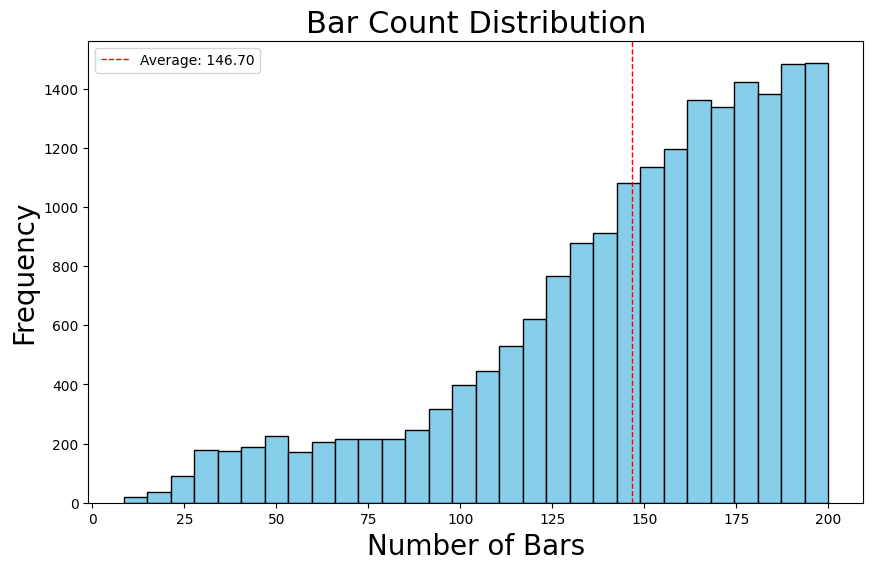

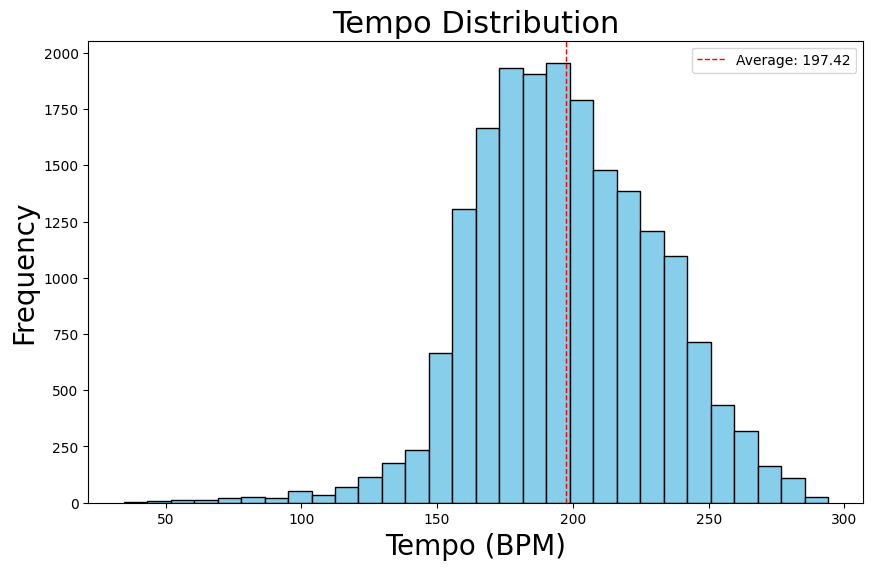

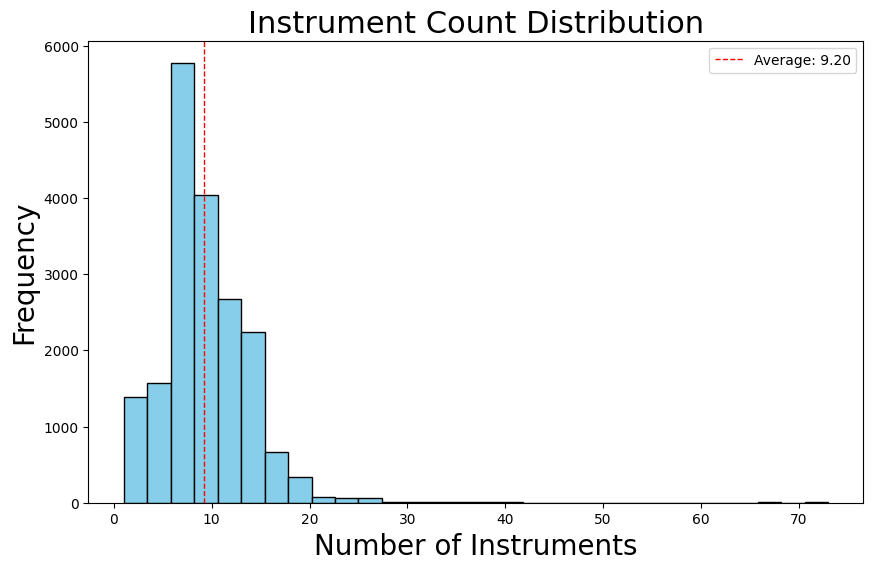

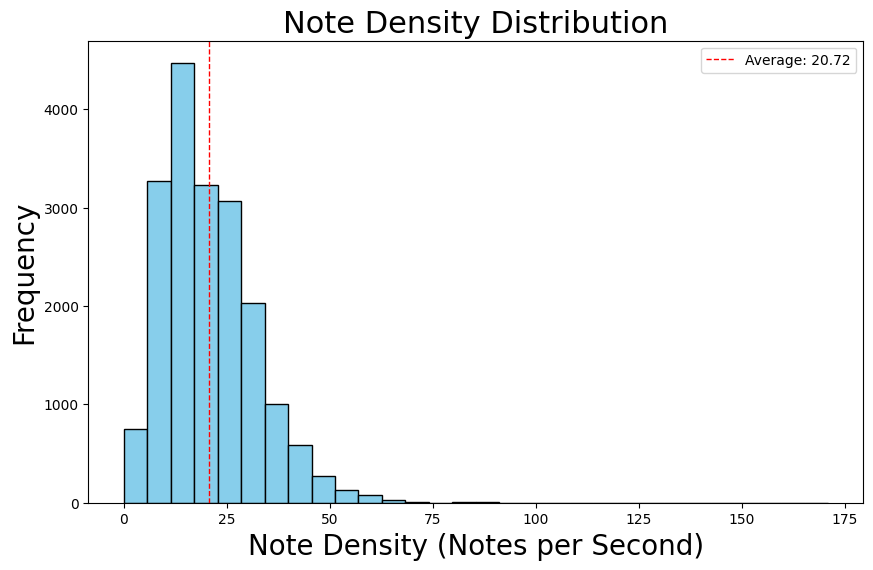

In [7]:
def plot_histogram(data, title, xlabel, ylabel, average):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=30, color='skyblue', edgecolor='black')
    plt.axvline(average, color='r', linestyle='dashed', linewidth=1, label=f'Average: {average:.2f}')
    plt.title(title, fontsize = 22)
    plt.xlabel(xlabel, fontsize = 20)
    plt.ylabel(ylabel, fontsize = 20)
    plt.legend()
    plt.show()

# Calculate the average for bar counts
avg_bars = sum(k * v for k, v in bar_counts.items()) / sum(bar_counts.values())
# Convert dictionary to a list for histogram
bar_list = [k for k, v in bar_counts.items() for _ in range(v)]
plot_histogram(bar_list, 'Bar Count Distribution', 'Number of Bars', 'Frequency', avg_bars)

# Calculate the average for tempo
avg_tempo = sum(k * v for k, v in tempo_counts.items()) / sum(tempo_counts.values())
# Convert dictionary to a list for histogram
tempo_list = [k for k, v in tempo_counts.items() for _ in range(v)]
plot_histogram(tempo_list, 'Tempo Distribution', 'Tempo (BPM)', 'Frequency', avg_tempo)

# Calculate the average for instrument count
avg_instruments = sum(k * v for k, v in instrument_count.items()) / sum(instrument_count.values())
# Convert dictionary to a list for histogram
instrument_list = [k for k, v in instrument_count.items() for _ in range(v)]
plot_histogram(instrument_list, 'Instrument Count Distribution', 'Number of Instruments', 'Frequency', avg_instruments)

# Calculate the average note density
avg_density = sum(k * v for k, v in density_count.items()) / sum(density_count.values())
density_list = [k for k, v in density_count.items() for _ in range(v)]
plot_histogram(density_list, 'Note Density Distribution', 'Note Density (Notes per Second)', 'Frequency', avg_density)


## Create tokenizer

In [5]:
# Create the tokenizers

# Our parameters
TOKENIZER_PARAMS = {
    "pitch_range": (21, 109), # Which note
    "beat_res": {(0, 4): 12, (4, 12): 4}, # Breakdown of the bars
    "num_velocities": 32,
    "special_tokens": ["PAD", "BOS", "EOS", "MASK"], 
    "use_chords": True,
    "use_rests": True,
    "use_tempos": True,
    "use_time_signatures": True,
    "use_programs": True,
    "num_tempos": 32,  # nb of tempo bins
    "tempo_range": (40, 250),  # (min, max)
    "max_bar_embedding": 500,
    "drum_pitch_range": (0, 127),
}
config = TokenizerConfig(**TOKENIZER_PARAMS)

# Creates the tokenizer
REMI_tokenizer = REMI(config)

In [6]:
REMI_tokenizer.vocab

{'PAD_None': 0,
 'BOS_None': 1,
 'EOS_None': 2,
 'MASK_None': 3,
 'Bar_0': 4,
 'Bar_1': 5,
 'Bar_2': 6,
 'Bar_3': 7,
 'Bar_4': 8,
 'Bar_5': 9,
 'Bar_6': 10,
 'Bar_7': 11,
 'Bar_8': 12,
 'Bar_9': 13,
 'Bar_10': 14,
 'Bar_11': 15,
 'Bar_12': 16,
 'Bar_13': 17,
 'Bar_14': 18,
 'Bar_15': 19,
 'Bar_16': 20,
 'Bar_17': 21,
 'Bar_18': 22,
 'Bar_19': 23,
 'Bar_20': 24,
 'Bar_21': 25,
 'Bar_22': 26,
 'Bar_23': 27,
 'Bar_24': 28,
 'Bar_25': 29,
 'Bar_26': 30,
 'Bar_27': 31,
 'Bar_28': 32,
 'Bar_29': 33,
 'Bar_30': 34,
 'Bar_31': 35,
 'Bar_32': 36,
 'Bar_33': 37,
 'Bar_34': 38,
 'Bar_35': 39,
 'Bar_36': 40,
 'Bar_37': 41,
 'Bar_38': 42,
 'Bar_39': 43,
 'Bar_40': 44,
 'Bar_41': 45,
 'Bar_42': 46,
 'Bar_43': 47,
 'Bar_44': 48,
 'Bar_45': 49,
 'Bar_46': 50,
 'Bar_47': 51,
 'Bar_48': 52,
 'Bar_49': 53,
 'Bar_50': 54,
 'Bar_51': 55,
 'Bar_52': 56,
 'Bar_53': 57,
 'Bar_54': 58,
 'Bar_55': 59,
 'Bar_56': 60,
 'Bar_57': 61,
 'Bar_58': 62,
 'Bar_59': 63,
 'Bar_60': 64,
 'Bar_61': 65,
 'Bar_62': 66,
 'Bar_

Use this to load in a previous BPE configured tokeniser if jupyter crashes

In [7]:
load_path = r"C:\Users\DfHal\PycharmProjects\GPU_Test\remi_tokenizer_bpe.config"
REMI_tokenizer._load_params(load_path)

## Create REMI tokens from midi data

In [25]:
#Convert midi to REMI tokens, store in directory
source_directory = r'G:\FYP\Lahk_Matched\MIDI_folder\bar_midis_largest' # Source directory with MIDI files
tokens_path = Path(r'G:\FYP\Lahk_Matched\REMI_folder\REMI_tokens_largest')  # Destination directory for tokens

midi_paths = list(Path(source_directory).glob('**/*.mid')) + list(Path(source_directory).glob('**/*.midi'))
REMI_tokenizer.tokenize_midi_dataset(midi_paths, tokens_path)


Tokenizing MIDIs (REMI_folder/REMI_tokens_largest): 100%|██████████| 18939/18939 [2:00:18<00:00,  2.62it/s]  


## Learn and apply BPE (Byte Pair Encoding) to REMI tokens

Save the tokenizer in case of crash 

In [7]:
remi_tokens_path = Path('G:\FYP\Lahk_Matched\REMI_folder\REMI_tokens_largest')
remi_bpe_path = 'G:\FYP\Lahk_Matched\REMI_folder\REMI_BPE_5k'

REMI_tokenizer.learn_bpe(
    vocab_size=5000,
    tokens_paths=list(remi_tokens_path.glob("**/*.json")),
    start_from_empty_voc=False,
)
REMI_tokenizer.save_params("remi_tokenizer_bpe.config")
REMI_tokenizer.apply_bpe_to_dataset(
    remi_tokens_path,
    remi_bpe_path
)

Applying BPE to dataset: 100%|██████████| 18783/18783 [08:32<00:00, 36.65it/s]


## Now we have BPE of REMI tokens we can split into training, validation  and test set

In [8]:
remi_bpe_path = 'G:\FYP\Lahk_Matched\REMI_folder\REMI_BPE_5k'

In [9]:
remi_bpe_path = Path(remi_bpe_path)
REMI_paths = list(remi_bpe_path.glob('**/*.json'))

In [10]:
# Split to train and test sets
total_num_files = len(REMI_paths)
num_files_valid = round(total_num_files * 0.1)
num_files_test = round(total_num_files * 0.1)
shuffle(REMI_paths)


remi_paths_valid = REMI_paths[:num_files_valid]
remi_paths_test = REMI_paths[num_files_valid:num_files_valid + num_files_test]
remi_paths_train = REMI_paths[num_files_valid + num_files_test:]


## Set minimum and maximum sequence lengths for training data.

In [11]:
REMIargs_dataset = {"min_seq_len": 256, "max_seq_len": 2048, "tokenizer": REMI_tokenizer}

remi_dataset_train = DatasetTok(remi_paths_train, **REMIargs_dataset)
remi_dataset_valid = DatasetTok(remi_paths_valid, **REMIargs_dataset)
remi_dataset_test = DatasetTok(remi_paths_test, **REMIargs_dataset)
# Collator auto pads data for me during training
remi_collator = DataCollator(
    REMI_tokenizer["PAD_None"], # Pad token
    REMI_tokenizer["BOS_None"], # BOS TOKEN
    REMI_tokenizer["EOS_None"], # EOS TOKEN
    pad_on_left=False, # pad on right
    copy_inputs_as_labels=True,  
    shift_labels=False,  
    labels_pad_idx=-100 # This is the padding id for hugging face transformers.
    )  

Loading data: G:\FYP\Lahk_Matched\REMI_folder\REMI_BPE_5k: 100%|██████████| 15027/15027 [00:23<00:00, 636.77it/s]
Loading data: G:\FYP\Lahk_Matched\REMI_folder\REMI_BPE_5k: 100%|██████████| 1878/1878 [00:02<00:00, 633.05it/s]
Loading data: G:\FYP\Lahk_Matched\REMI_folder\REMI_BPE_5k: 100%|██████████| 1878/1878 [00:03<00:00, 621.97it/s]


## Initialise and define Mistral model

In [13]:
model_config= MistralConfig(
    vocab_size=len(REMI_tokenizer),
    hidden_size=512,
    intermediate_size=1024,
    num_hidden_layers=8,
    num_attention_heads=4,
    num_key_value_heads=2,
    sliding_window=512,
    max_position_embeddings=8192,
    pad_token_id=REMI_tokenizer['PAD_None'],
    bos_token_id=REMI_tokenizer['BOS_None'],
    eos_token_id=REMI_tokenizer['EOS_None']
)


In [14]:
remi_model = AutoModelForCausalLM.from_config(model_config)

## Custom defined functions to help with computing metrics and preprocessing logits for prediction

In [15]:
metrics = {metric: load_metric(metric) for metric in ["accuracy"]}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    not_pad_mask = labels != -100
    labels, predictions = labels[not_pad_mask], predictions[not_pad_mask]
    return metrics["accuracy"].compute(predictions=predictions.flatten(), references=labels.flatten())

def preprocess_logits(logits: Tensor, _: Tensor) -> Tensor:
    pred_ids = argmax(logits, dim=-1)  # long dtype
    return pred_ids

## Initialise the training hyper-parameters, making use of CUDA

In [38]:
# Create config for the Trainer
USE_CUDA = cuda_available()
if not cuda_available():
    FP16 = FP16_EVAL = BF16 = BF16_EVAL = False
elif is_bf16_supported():
    BF16 = BF16_EVAL = True
    FP16 = FP16_EVAL = False
else:
    BF16 = BF16_EVAL = False
    FP16 = FP16_EVAL = True
USE_MPS = not USE_CUDA and mps_available()

training_config = TrainingArguments(
    r"G:\FYP\V3.3", 
    False, 
    True, 
    True, 
    False, 
    "epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=16,
    eval_accumulation_steps=None,
    eval_steps=10,
    learning_rate=1e-3,
    weight_decay=0.01,
    max_grad_norm=3.0,
    num_train_epochs=10,
    #max_steps=2000,
    lr_scheduler_type="cosine_with_restarts",
    warmup_ratio=0.3,
    logging_dir= "G:\FYP\V3\logs",
    logging_first_step=True,
    log_level="debug",
    logging_strategy="epoch",
    logging_steps=10,
    save_strategy="epoch",
    save_total_limit=100,
    save_steps=10,
    no_cuda=not USE_CUDA,
    seed=42,
    fp16=FP16,
    fp16_full_eval=FP16_EVAL,
    bf16=BF16,
    bf16_full_eval=BF16_EVAL,
    load_best_model_at_end=True,
    label_smoothing_factor=0.,
    optim="adamw_torch",
    report_to=["tensorboard"],
    gradient_checkpointing=False,
    disable_tqdm=True,
    dataloader_num_workers=4
)


PyTorch: setting up devices


Use this to load in model checkpoints

In [39]:
remi_model = AutoModelForCausalLM.from_pretrained(r"G:\FYP\V3.3\checkpoint-12037")

loading configuration file G:\FYP\V3.3\checkpoint-12037\config.json
Model config MistralConfig {
  "_name_or_path": "G:\\FYP\\V3.3\\checkpoint-12037",
  "architectures": [
    "MistralForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "max_position_embeddings": 8192,
  "model_type": "mistral",
  "num_attention_heads": 4,
  "num_hidden_layers": 8,
  "num_key_value_heads": 2,
  "pad_token_id": 0,
  "rms_norm_eps": 1e-06,
  "rope_theta": 10000.0,
  "sliding_window": 512,
  "tie_word_embeddings": false,
  "torch_dtype": "float32",
  "transformers_version": "4.37.0",
  "use_cache": true,
  "vocab_size": 5000
}

loading weights file G:\FYP\V3.3\checkpoint-12037\model.safetensors
Generate config GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": 2,
  "pad_token_id": 0
}

All model checkpoint weights were used when initializing MistralForCausalLM

In [40]:
print(remi_model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(5000, 512, padding_idx=0)
    (layers): ModuleList(
      (0-7): 8 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear(in_features=512, out_features=512, bias=False)
          (k_proj): Linear(in_features=512, out_features=256, bias=False)
          (v_proj): Linear(in_features=512, out_features=256, bias=False)
          (o_proj): Linear(in_features=512, out_features=512, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=512, out_features=1024, bias=False)
          (up_proj): Linear(in_features=512, out_features=1024, bias=False)
          (down_proj): Linear(in_features=1024, out_features=512, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): MistralRMSNorm()
  )
 

## Define the trainer and begin training with early stopping

In [ ]:
#remi_collator = DataCollator(REMI_tokenizer["PAD_None"], REMI_tokenizer["BOS_None"], REMI_tokenizer["EOS_None"], copy_inputs_as_labels=True)
remi_trainer = Trainer(
    model=remi_model,
    args=training_config,
    data_collator=remi_collator,
    train_dataset=remi_dataset_train,
    eval_dataset=remi_dataset_valid,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    preprocess_logits_for_metrics=preprocess_logits,
)

# Training
print("Training commencing....")
train_result = remi_trainer.train()
print("Training complete.")
remi_trainer.save_model()  # Saves the tokenizer too
remi_trainer.log_metrics("train", train_result.metrics)
remi_trainer.save_metrics("train", train_result.metrics)
remi_trainer.save_state()

## Define and initialise generation configuration hyper-Parameters

In [28]:
(gen_results_path := Path('G:\\FYP\\Generation\\3.2')).mkdir(parents=True, exist_ok=True)
generation_config = GenerationConfig(
    max_new_tokens=4096,
    min_new_tokens=2048,
    num_beams=1,        
    do_sample=True,     
    temperature=0.50,
    top_k=10,
    top_p=0.90,
    epsilon_cutoff=3e-4,
    eta_cutoff=3e-3,
    no_repeat_ngram_size= 8,
    pad_token_id=REMI_tokenizer.vocab.get('PAD_None'),
    bos_token_id=REMI_tokenizer.vocab.get('BOS_None'),
    eos_token_id=REMI_tokenizer.vocab.get('EOS_None')
)

In [29]:
import random
remi_collator.pad_on_left = True
remi_collator.eos_token = None
dataloader_test = DataLoader(remi_dataset_test, batch_size=4, collate_fn=remi_collator)
remi_model.eval()

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(5000, 512, padding_idx=0)
    (layers): ModuleList(
      (0-7): 8 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear(in_features=512, out_features=512, bias=False)
          (k_proj): Linear(in_features=512, out_features=256, bias=False)
          (v_proj): Linear(in_features=512, out_features=256, bias=False)
          (o_proj): Linear(in_features=512, out_features=512, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=512, out_features=1024, bias=False)
          (up_proj): Linear(in_features=512, out_features=1024, bias=False)
          (down_proj): Linear(in_features=1024, out_features=512, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): MistralRMSNorm()
  )
 

## Generate MIDI music files. Returns the prompt file and the generated file

In [ ]:
count =  0
for batch in tqdm(dataloader_test, desc='Testing model / Generating results'):  # (N,T)
    # First generation
    res = remi_model.generate(
        inputs=batch["input_ids"].to(remi_model.device),
        attention_mask=batch["attention_mask"].to(remi_model.device),
        generation_config=generation_config)  # (N,T)
    
    # Process each prompt and its corresponding generated music
    for prompt, generated1 in zip(batch["input_ids"], res):
        # Create MIDI for the prompt
        prompt_midi = REMI_tokenizer.tokens_to_midi(deepcopy(prompt.tolist()))
        prompt_midi.dump(gen_results_path / f'prompt_{count}.mid')
        
        # Create MIDI for the first generated music
        generated_midi1 = REMI_tokenizer.tokens_to_midi(deepcopy(generated1[len(prompt):].tolist()))
        generated_midi1.dump(gen_results_path / f'generated_{count}.mid')
        
        count +=  1
